In [98]:

import os
import sys
import pickle
import warnings
import time
import logging
import glob

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf

from utils import *
from AnalyseDefects_dev import AnalyseDefects

plt.style.use('sg_article')

def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}', \
              suffix = "short", priority = 0, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}l', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path =  f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LL}vl', \
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    
    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

TODO:

- take into account that acf might fail at low act. Eg by discarding acf for tau < 5 or something in the crit region


0.019 200
0.0195 200
0.02 200
0.021 200
0.0215 200
0.022 200
0.0225 200
[        inf 15.46738046 30.74750906 41.21158812 39.2048432  32.5883905
 85.62318942]
[         inf  19.70736087  36.7017017   46.30697205  47.03398911
  38.58539006 115.62271062]


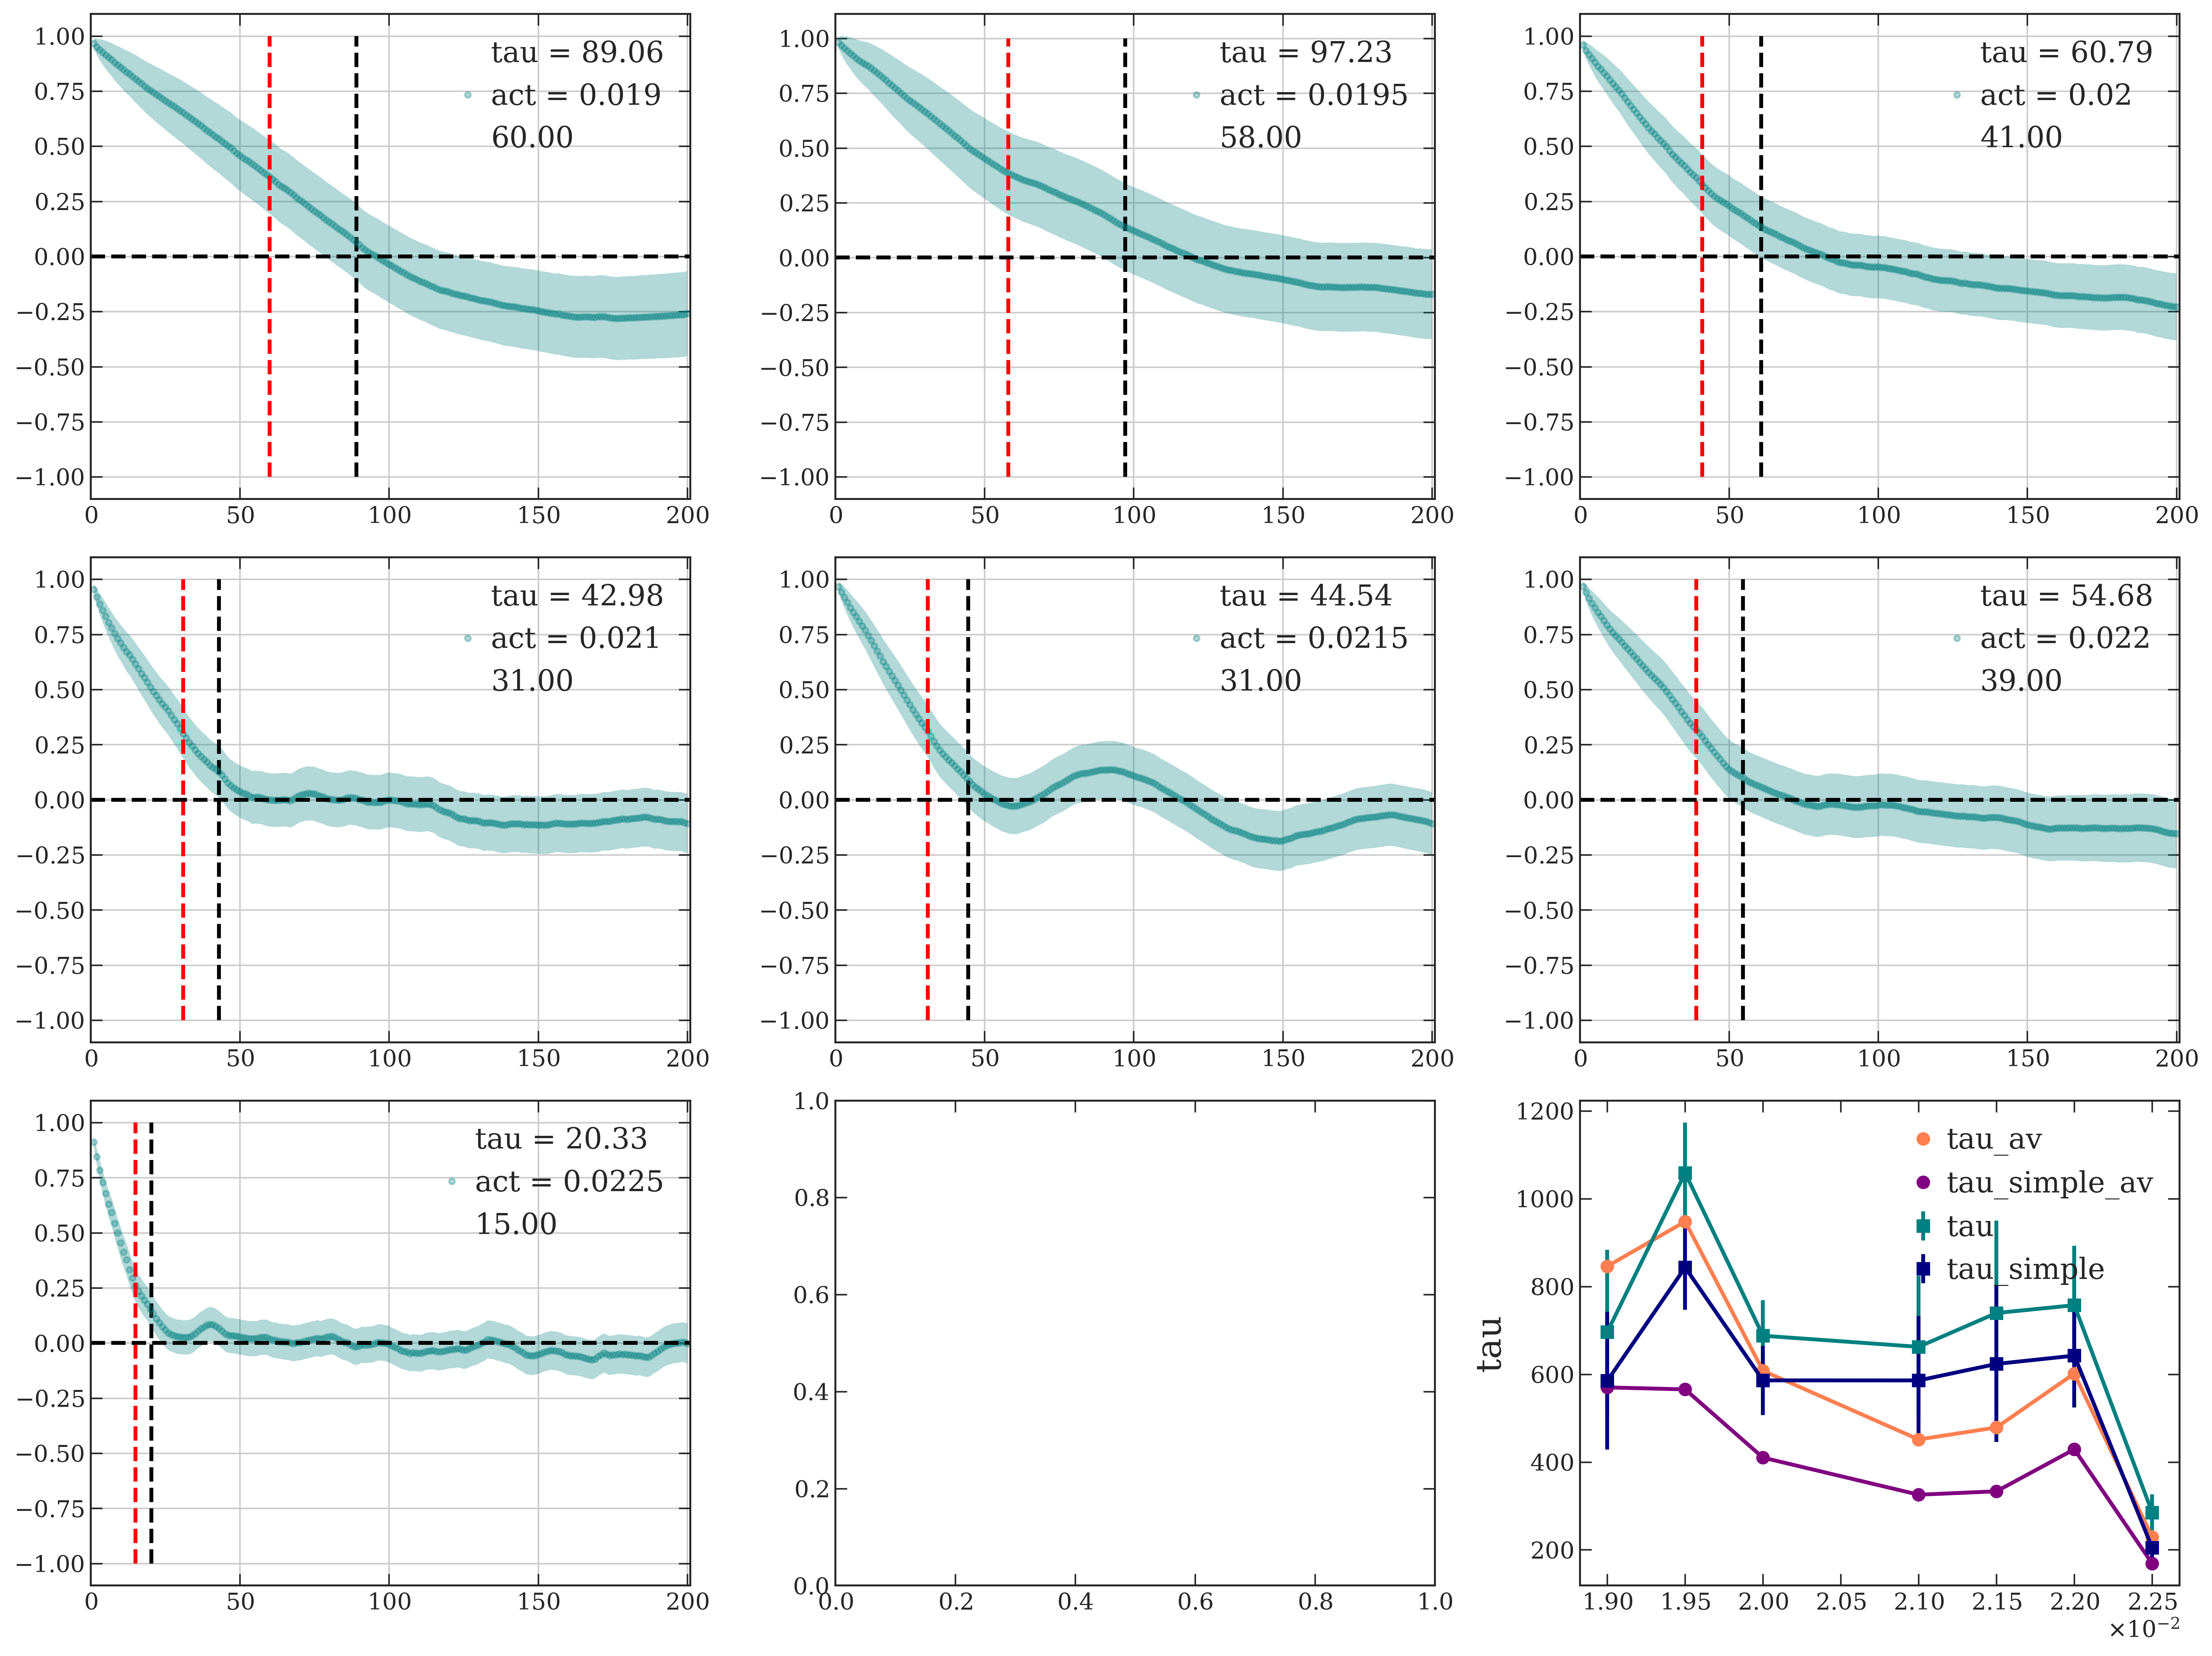

In [149]:

LL = 2048
output_path = f'data\\na{LL}'

mode = 'all' # 'all' or 'short'
find_nlag_orig = True
defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

N = -1
ninfo=500
def_arr = ad.get_arrays_full(Ndataset=N)[0]
kbins, sfac = ad.get_sfac_pcf(Ndataset=N, time_av=False)[:2]
act_list = ad.act_list[N]
conv_list = ad.conv_list[N] 

act_list = ad.act_list[N]
Nexp = ad.Nexp[N]
ndist_arr = np.zeros((len(act_list), Nexp, 2)) 
neff_arr = np.zeros((len(act_list)))
neff_arr_simple = np.zeros((len(act_list)))
tau_av_arr = np.zeros((len(act_list), 2))

use_error_bound = False
max_lag = None
alpha = 1 - 0.3413 * 2
threshold_eff_sample = 0
simple_threshold = 0.2

nrows = len(act_list) // 3 + 1 #if len(act_list) % 3 != 0 else len(act_list) // 3
fig, ax = plt.subplots(ncols = 3, nrows = nrows, figsize=(16, 4*nrows))
ax = ax.flatten()

def fit_exp(t, tau, beta):
                    return beta * np.exp(- t / tau)

param_guess = np.array([0.9, 30])
fit_string = r'$y = \beta e^{(-t/ \tau_0)}$'
Nparams = len(param_guess)

for j, act in enumerate(act_list[:]):
    act_idx = act_list.index(act)

    conv_idx = 1100 if LL < 2048 else 0
    if find_nlag_orig:
        #conv_idx = 750 #conv_list[act_idx]
        lag_frac = .7
        nf = def_arr.shape[0] - conv_idx
        nlags= int(750/2 if LL < 2048 else 400/2) 
        nlags=200
        nlags = int(min(nf * nlags, nlags))
    else:
       # conv_idx = conv_list[act_idx]
        lag_frac = .5
        nf = def_arr.shape[0] - conv_idx
        nlags = int(nf * lag_frac)

    print(act, nlags)
   # nlags=500
    #conv_idx=500#1100
    frames = np.arange(nlags +1)
    acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)

    confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

    acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
    tau_av, tau_simple_av = estimate_effective_sample_size(acf_avg, confint_avg,
                            max_lag_threshold=threshold_eff_sample, simple_threshold=simple_threshold, max_lag=max_lag,)
    tau_av_arr[j] = tau_av, tau_simple_av


    ax[j].vlines(tau_av, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau_av:.2f}')
    ax[j].plot(frames, acf_avg, '.', alpha=.3, label = f'act = {act}')  
    ax[j].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
    ax[j].vlines(tau_simple_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(tau_simple_av))

    ax[j].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
    ax[j].set_xlim(0, len(frames))
    ax[j].grid(True)
    ax[j].legend();
   # ax[j].set_yscale('log') 

    for k in range(Nexp):
        if LL==512 and act == 0.0195 and k == 7:
            continue
      #  if LL==256 and act == 0.021 and k in [0,1,6,7,8,9]:
       #     continue
        if LL==256 and act == 0.0205 and k in [8,]:
            continue
        if LL==256 and act == 0.020 and k in [1,2]:
            continue
        if LL==256 and act == 0.022 and k in [5]:
            continue
        if LL==256 and act == 0.0195 and k in [0,1, 3, 5, 6,9]:
            continue
        if LL==1024 and act == 0.019 and k in [0]:
            continue
        if LL==2048 and act == 0.019 and k in [0]:
            continue

        acf_vals = acf_arr[- (nlags + 1):,k]
        confint_vals = confint_arr[- (nlags + 1):,:,k]

        tau, tau_simple = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, 
                                                    max_lag_threshold=threshold_eff_sample,
                                                    simple_threshold = simple_threshold, use_error_bound=use_error_bound)

        ndist_arr[j, k] = [tau, tau_simple]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        neff_arr[j] = np.nansum(nf / ndist_arr[j,:,0])
        neff_arr_simple[j] = np.nansum(nf / ndist_arr[j,:,1])

normalize = True
multiplier = ninfo * np.array(act_list) #np.ones_like(act_list)
multiplier[-3] *= 1 #8 if LL == 1024 else 1
ndist_arr *= multiplier[:,None,None] 
tau_av_arr *= multiplier[:,None]

ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,0], axis=1), np.nanstd(ndist_arr[:,:,0], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau')
ax[-1].errorbar(act_list, np.nanmean(ndist_arr[:,:,1], axis=1), np.nanstd(ndist_arr[:,:,1], axis=1, ddof = 1) / np.sqrt(Nexp), marker='s', label='tau_simple')
ax[-1].plot(act_list, tau_av_arr[:,0], 'o-', label='tau_av')
ax[-1].plot(act_list, tau_av_arr[:,1], 'o-', label='tau_simple_av')
#ax[-1].plot(act_list, ndist_arr[:,0,1], 'o-', label='tau_simple')
#ax[-1].set_xlabel('activity')
ax[-1].set_ylabel('tau')
ax[-1].legend()

print(neff_arr)
print(neff_arr_simple)

In [ ]:
act = 0.019
act_idx = act_list.index(act)
alpha = 1 - 0.3413 * 2

conv_idx = conv_list[act_idx]
nf = def_arr.shape[0] - conv_idx
nlags= int(nf / 2)  
acf_arr, confint_arr = calc_acf_for_arr(def_arr[:, act_idx, :], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
#acf_arr, confint, qstat, pvals = acf(def_arr[conv_list[act_idx]:,act_idx,0], nlags=500, qstat=True, alpha=0.05)


fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 16))
ax = ax.flatten()
threshold = .2 #0#.1
threshold_eff_sample = 0 #0.1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None # min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau, first_frame_confint_zero = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, 
                                                    use_abs_sum=use_abs_sum,
                                                    max_lag_threshold=threshold_eff_sample
                                                    )
      #  first_frame_confint_zero = np.where(confint_vals[:,0] < np.abs(threshold))[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau, first_frame_confint_zero_avg = estimate_effective_sample_size(acf_avg, confint_avg, max_lag_threshold=threshold_eff_sample, max_lag=max_lag, use_abs_sum=use_abs_sum)
#first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < np.abs(threshold))[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (nf / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * nf / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

#first_frame_confint_zero_av = np.where(conf[:,0] < np.abs(threshold))[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau, first_frame_confint_zero_av = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, 
                                           use_abs_sum=use_abs_sum, max_lag_threshold=threshold_eff_sample)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * nf / tau).sum())  

In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()
threshold = .1
use_abs_sum = False
tau_arr = np.zeros(acf_arr.shape[-1])
max_lag = None# min(nlags, 1000)

for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        # find max_lag as when acf is below threshold
      #  max_lag = np.where(acf_vals < threshold)[0][0]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None,\
                                                    confint_vals =confint_vals, max_lag=max_lag, use_abs_sum=use_abs_sum)
        first_frame_confint_zero = np.where(confint_vals[:,0] < threshold)[0][0]
        tau_arr[i] = tau

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(frames), color='black', linestyles='dashed')
        axx.set_xlim(0, len(frames))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
#max_lag = np.where(acf_avg < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0, max_lag=max_lag, use_abs_sum=use_abs_sum)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < threshold)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();


ind_samp_tot = (1500 / tau_arr).sum()

print(f'ind_samp_tot = {ind_samp_tot:.2f}')

print('ind samples mean acf: ', (len(tau_arr) * 1500 / tau).sum())  

# finally, calc acf of mean 
def_arr_av = np.nanmean(def_arr[:nf, act_idx, :], axis = -1)
def_arr_std = np.nanstd(def_arr[:nf, act_idx, :], axis = -1, ddof=1) / np.sqrt(def_arr.shape[-1])
#acf_arr_av, confint_arr_av = calc_acf_for_arr(def_arr_av[:, None], conv_idx = conv_idx, nlags = nlags, alpha = alpha)
ac, conf = acf(def_arr_av[:nf], nlags = nlags, alpha = alpha)

first_frame_confint_zero_av = np.where(conf[:,0] < threshold)[0][0]
#max_lag = np.where(ac < threshold)[0][0]
Neff, tau = estimate_effective_sample_size(ac, acf_err_vals=None, confint_vals =conf, max_lag=max_lag, use_abs_sum=use_abs_sum)#, max_lag=max_lag)
ax[-1].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}') 
ax[-1].vlines(first_frame_confint_zero_av, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_av))
ax[-1].plot(frames, ac, '.', alpha=.3)
ax[-1].fill_between(frames, conf[:,0], conf[:,1], alpha=.3)
ax[-1].hlines(0, 0, len(frames), color='black', linestyles='dashed')
ax[-1].set_xlim(0, len(frames))
ax[-1].grid(True)
ax[-1].legend();

print('ind samp acf of mean: ', (len(tau_arr) * 1500 / tau).sum())  


In [ ]:

fig, ax = plt.subplots(ncols = 3, nrows = 4, figsize=(16, 24))
ax = ax.flatten()

nlags = 350


for i, axx in enumerate(ax):
    if i < acf_arr.shape[-1]:

        frames = np.arange(nlags +1)
        acf_vals = acf_arr[- (nlags + 1):,i]
        confint_vals = confint_arr[- (nlags + 1):,:,i]
        Neff, tau = estimate_effective_sample_size(acf_vals, acf_err_vals=None, confint_vals =confint_vals, threshold=0.1,)

        first_frame_confint_zero = np.where(confint_vals[:,0] < 0)[0][0]

        axx.plot(frames, acf_vals, '.', alpha=.3)
        axx.fill_between(frames, confint_vals[:,0], confint_vals[:,1], alpha=.3)
        
        axx.vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
        axx.vlines(first_frame_confint_zero, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero))
        axx.hlines(0, 0, len(acf_arr[conv_list[act_idx]:,i]), color='black', linestyles='dashed')
        axx.set_xlim(0, len(acf_arr[conv_list[act_idx]:,i]))

        axx.grid(True)
        axx.legend();

# now results for average acf.
# first calculate symmetric confint
confint_arr_sym = np.abs(confint_arr[:,1,:] - confint_arr[:,0,:]) / 2

acf_avg, confint_avg = calc_weighted_mean(acf_arr[-(nlags + 1):,:], confint_arr_sym[-(nlags + 1):,:])
Neff, tau = estimate_effective_sample_size(acf_avg, confint_avg, threshold=0.1,)
first_frame_confint_zero_avg = np.where(acf_avg - confint_avg < 0)[0][0]
ax[acf_arr.shape[-1]].vlines(tau, -1, 1, color='black', linestyles='dashed', label=f'tau = {tau:.2f}')
ax[acf_arr.shape[-1]].plot(frames, acf_avg, '.', alpha=.3)  
ax[acf_arr.shape[-1]].fill_between(frames, acf_avg - confint_avg, acf_avg + confint_avg, alpha=.3)
ax[acf_arr.shape[-1]].vlines(first_frame_confint_zero_avg, -1, 1, color='red', linestyles='dashed', label='{:.2f}'.format(first_frame_confint_zero_avg))

ax[acf_arr.shape[-1]].hlines(0, 0, len(frames), color='black', linestyles='dashed') 
ax[acf_arr.shape[-1]].set_xlim(0, len(frames))
ax[acf_arr.shape[-1]].grid(True)
ax[acf_arr.shape[-1]].legend();